In [2]:
%matplotlib inline
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.integrate import quad

In [1]:
import matplotlib.image as mpimg
from scipy.spatial import cKDTree, KDTree

In [11]:
def Ein_theta(D_l,D_s,m): #Function for Einstein Radius Using:D_l->distance to lens in units of [pc],
                            #D_s->distnace to source in units of [pc],m->mass of point source

    m_sun = 2.0e30 #solar mass in kg
    m = m * m_sun
    G = 6.67408e-11 #N m^2 kg^-2
    pc = 3.086e16 #pc to meters
    D_l = D_l*pc
    D_s = D_s*pc 
    D_ls = (D_s-D_l)*pc
    c = 299792458.0 # speed of light m/s
    
    return ((D_ls/(D_s*D_l))*(4.0*G*m/(c**2)))**(1/2)

In [17]:
def beta(theta,Ein_theta): #The Lens Equation defined in terms of the Einstein radius above

    return theta - Ein_theta**2/theta

In [13]:
Ein_1 = Ein_theta(5000,10000,3e9) #define lens mass of 3 billion m_sun at 5000 pc away and 5000 pc to lensed image
arc_conv = np.radians(0.01/60) #set resolution scale of 0.01 arcmin/pixel

In [14]:
#constructing a field space to apply the lensing equations to
x_1 = np.linspace(-10,10,1000) #define linespaced in x and y directions
y_1 = np.linspace(-10,10,1000)
X_1, Y_1 = np.meshgrid(x_1,y_1) #combine linespaces into 2-d gridspace
scalar_1 = 2.0
difX_1, difY_1 = np.meshgrid(np.linspace(-Ein_1, Ein_1,1000), np.linspace(-Ein_1, Ein_1, 1000))
difX_1 = difX_1 * scalar_1
difY_1 = difY_1 * scalar_1

In [19]:
polar_theta = np.arctan2(difX_1, difY_1) # polar conversion
theta_grav = np.sqrt(difX_1**2.0 + difY_1**2.0) # make theta agree with set resolution arc_conv

beta_grav = beta(theta_grav, Ein_1)
#convert to polar
polarX_1 = beta_grav * np.cos(polar_theta)
polarY_1 = beta_grav * np.sin(polar_theta)

In [20]:
#apply 2D nearest neighbor search or lookup from KDTree package
d_1 = cKDTree(np.array([difX_1.ravel(), difY_1.ravel()]).T)
d, idx = d_1.query(np.array([polarX_1.ravel(), polarY_1.ravel()]).T, k=1)

In [23]:
#define a 2D gaussian function to create point souce PSF images to apply the lens to
def Gauss_2d(x, y, mu_x, mu_y, sigma_x, sigma_y):
    norm = 1.0 / (2 * np.pi * sigma_x * sigma_y)
    exp = np.exp(-((x - mu_x)**2.0 / (2.0*sigma_x**2.0) + (y - mu_y)**2.0 / (2.0*sigma_y**2.0)))
    return norm * exp

In [24]:
Z_1 = Gauss_2d(X_1, Y_1, 0, 0, 0.5, 0.5)#create point souce PSF directly behind lens
Z_2 = Gauss_2d(X_1, Y_1, -2.5, -2, 0.5, 0.5)#create point source PSF on the inside odge of the lens Einstein radius

In [25]:
#use the KDTree lookup to pull pixel locations and apply lens equations to then generate lensed images
Values_1 = Z_1.ravel()[idx]
print (Values_1.shape)
print (Values_1[1])
Image_1 = np.asarray(Values_1).reshape(1000,1000)

Values_2 = Z_2.ravel()[idx]
print (Values_2.shape)
print (Values_2[1])
Image_2 = np.asarray(Values_2).reshape(1000,1000)

(1000000,)
1.39098994901e-133
(1000000,)
3.57795889885e-74


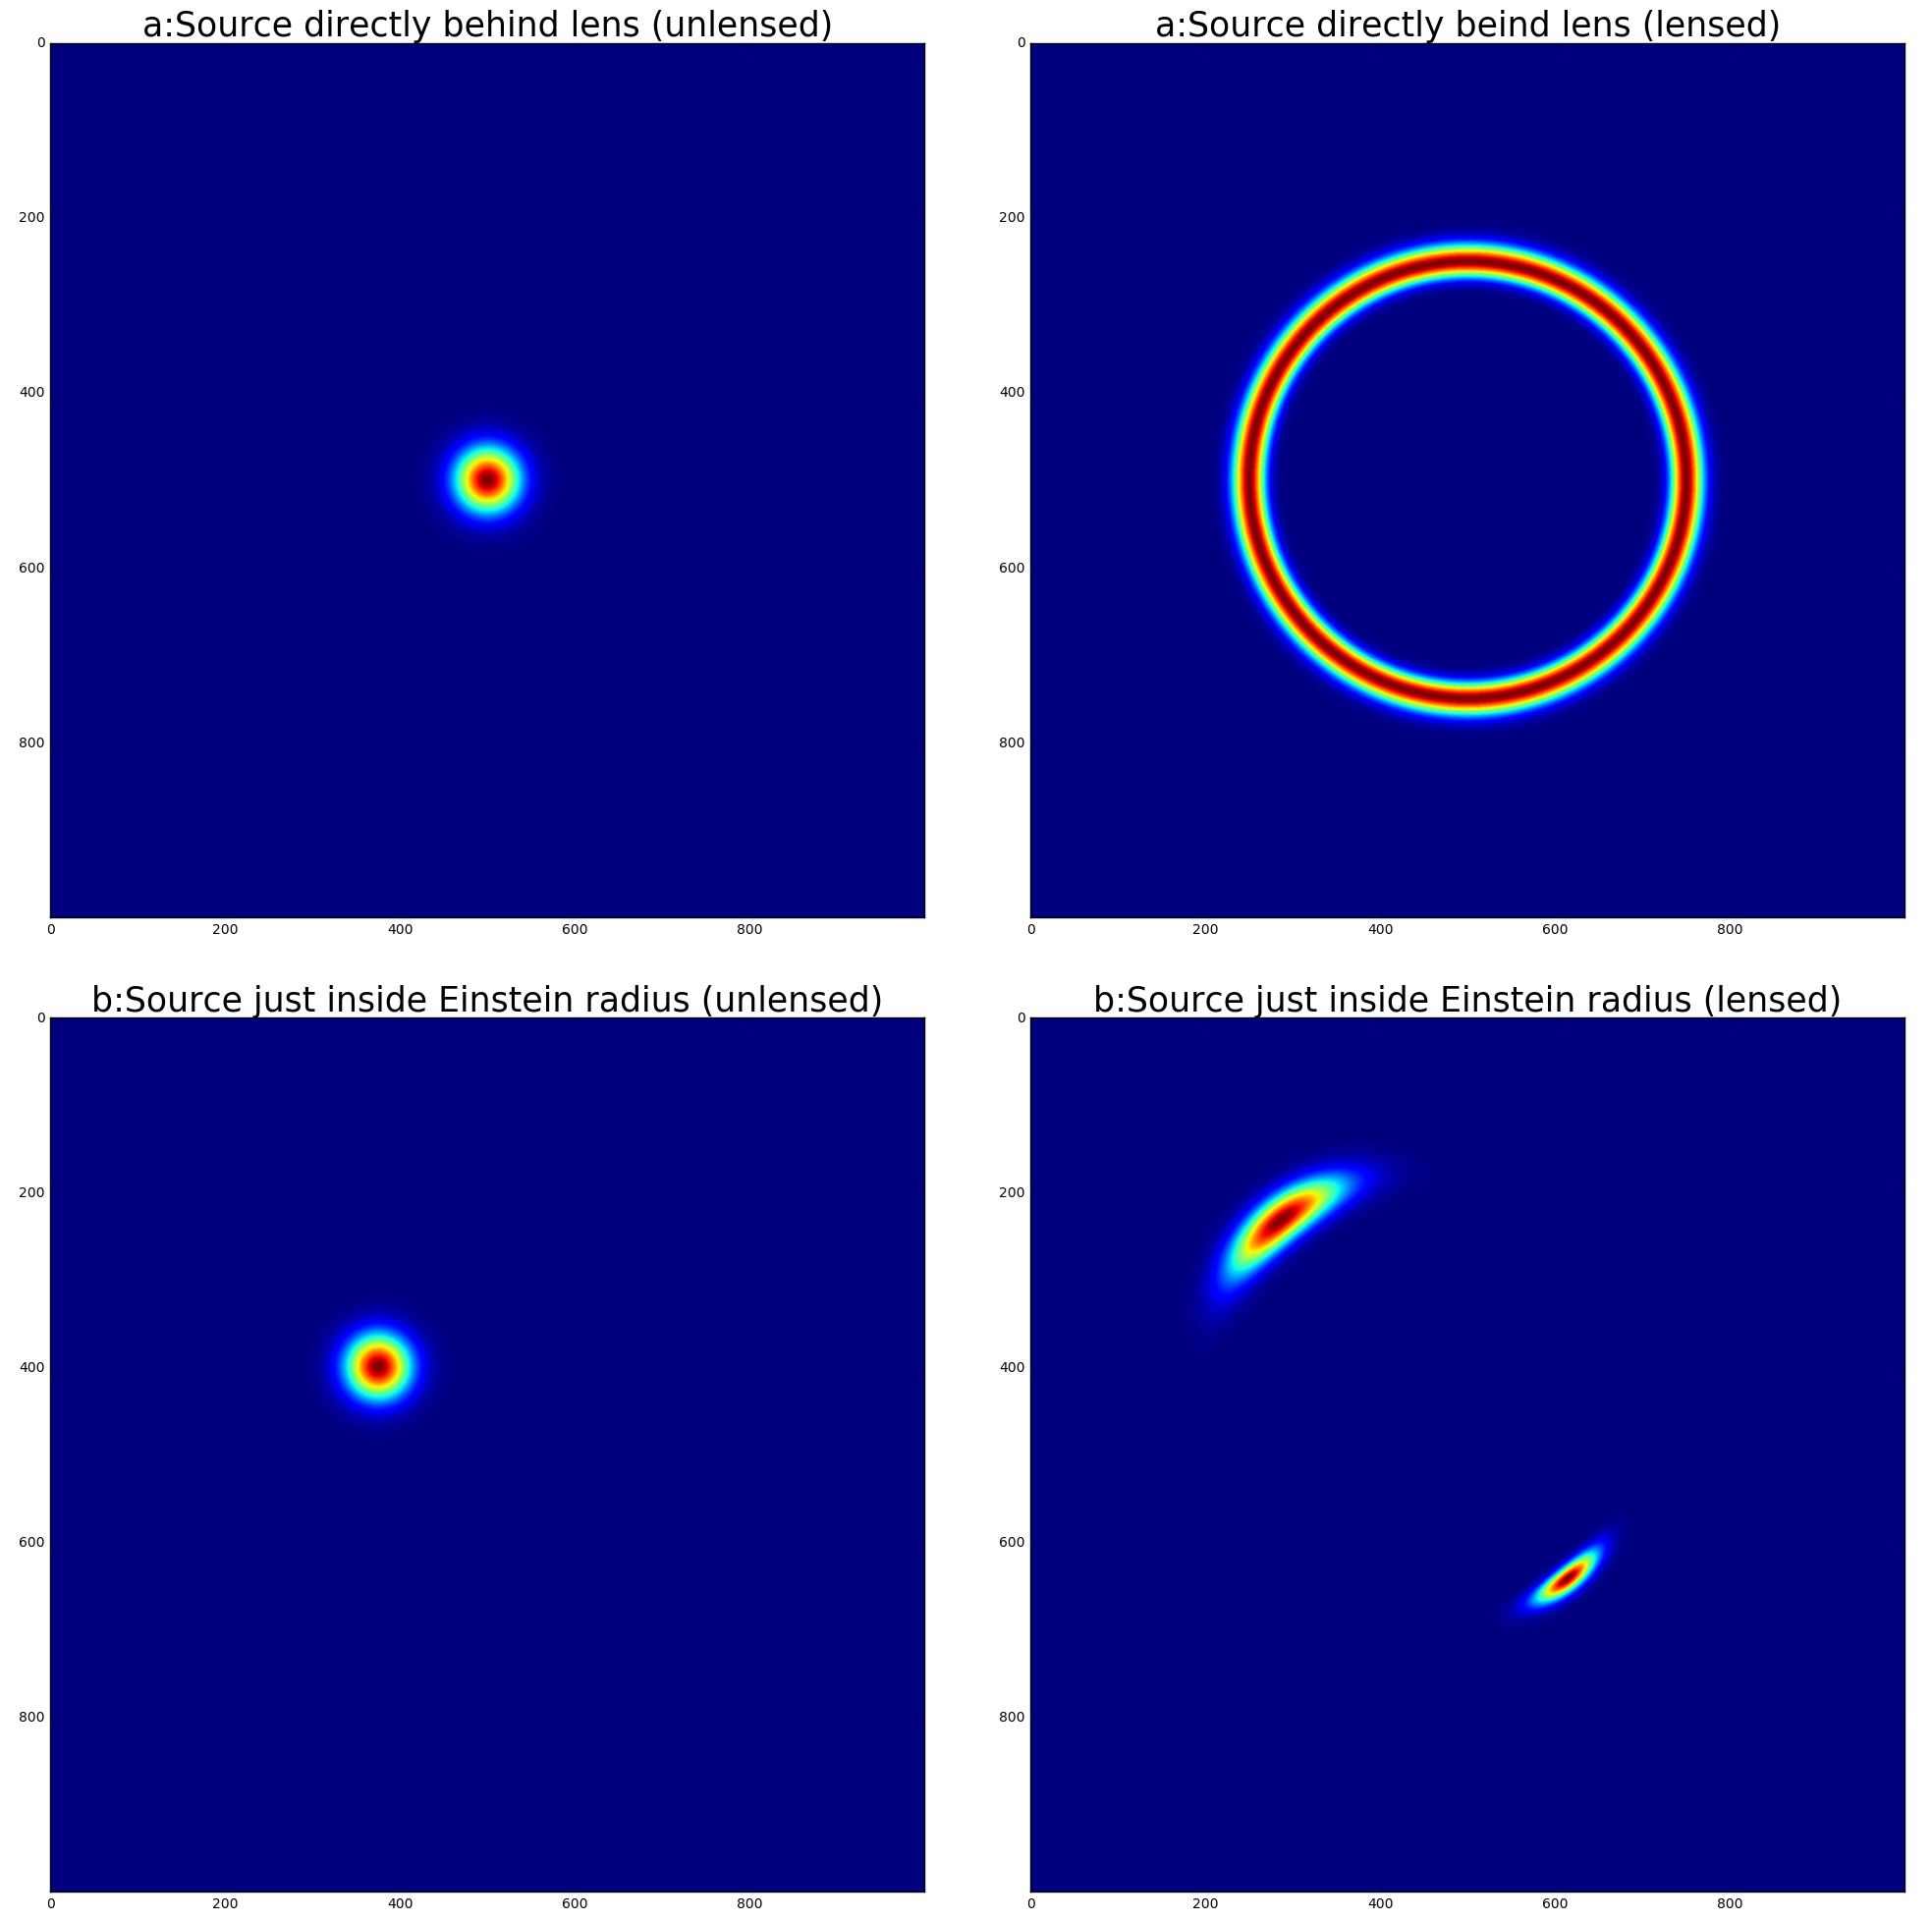

In [27]:
#plot source PSF and lensed images
fig, ax = plt.subplots(2,2,figsize=(20,20))
ax[0,0].imshow(Z_1)
ax[0,1].imshow(Image_1)
ax[1,0].imshow(Z_2)
ax[1,1].imshow(Image_2)

ax[0,0].set_title('a:Source directly behind lens (unlensed)',fontsize=25)
ax[0,1].set_title('a:Source directly beind lens (lensed)',fontsize=25)
ax[1,0].set_title('b:Source just inside Einstein radius (unlensed)',fontsize=25)
ax[1,1].set_title('b:Source just inside Einstein radius (lensed)',fontsize=25)
fig.tight_layout()
plt.show()

In [33]:
#apply lensing to an image, I selected the Hubble Extreme Deep Field
img=mpimg.imread('HubbleXDF.jpg')
Values_3 = img.ravel()[idx]
print (Values_3.shape)
print (Values_3[1])
Image_3 = np.asarray(Values_3).reshape(1000,1000)

(1000000,)
13


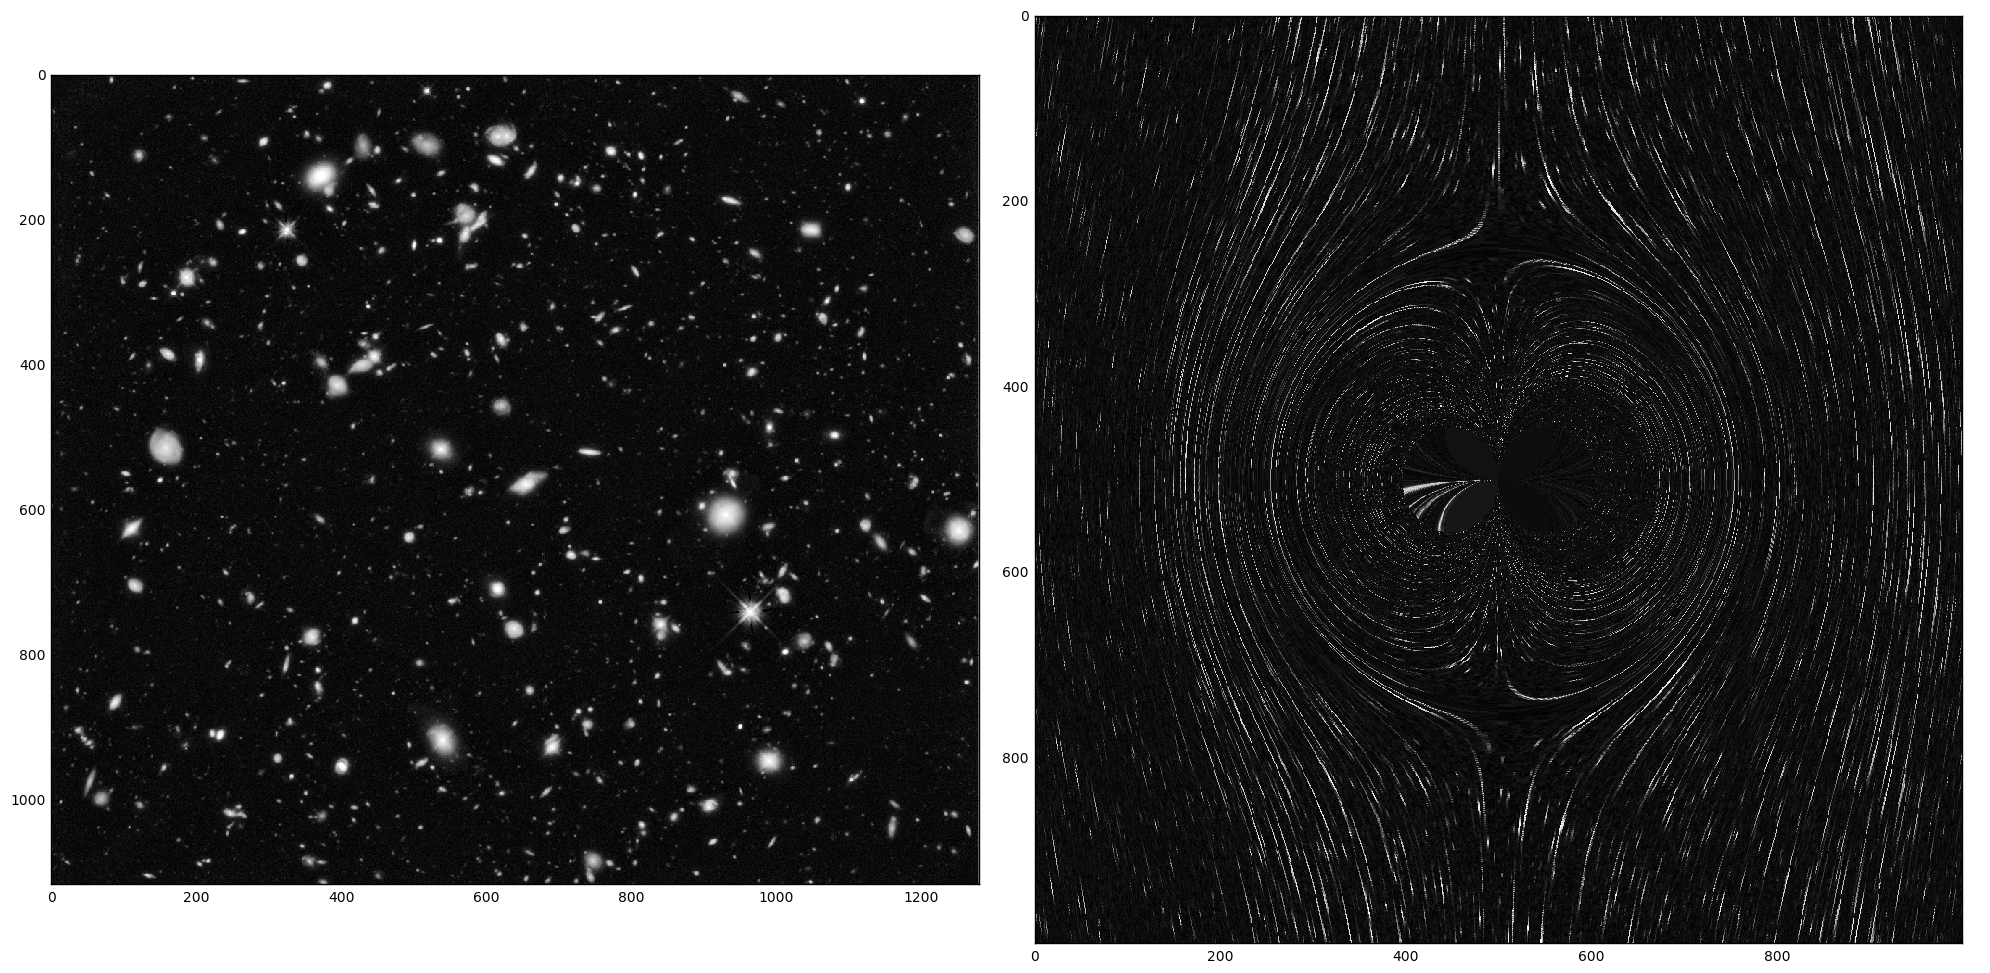

In [35]:
#plot lensed Hubble XDF
fig,(bx1,bx2) = plt.subplots(1,2,figsize=(20,20))
bx1.imshow(img[:,:,0],cmap='gray',interpolation='none')
bx2.imshow(Image_3,cmap='gray',interpolation='none')
fig.tight_layout()